# A real-world case (Physics: dynamics)

In this tutorial we will be using data from a real-world case. The data comes from a piecewise continuous function representing the gravitational interaction between two swarm of particles. It is of interest to represent such an interaction with a one only continuous function, albeit introducing some error. If succesfull, this would allow to have some analytical insight on the qualitative stability of the resulting orbits, as well as to make use of methods requiring high order continuity to study the resulting dynamical system.

The equation is (derived from a work by Francesco Biscani):
$$
a(x) = \left\{
\begin{array}{ll}
\frac{x^3 - 18x+32}{32} & x < 2 \\
\frac{1}{x^2} & x \ge 2
\end{array}
\right.
$$

It is important, on this problem, to respect the asymptotic behaviour of the acceleration so that $\lim_{x\rightarrow \infty}a(x) = \frac 1{x^2}$.

In [1]:
# Some necessary imports.
import dcgpy
import pygmo as pg
import numpy as np
# Sympy is nice to have for basic symbolic manipulation.
from sympy import init_printing
from sympy.parsing.sympy_parser import *
init_printing()
# Fundamental for plotting.
from matplotlib import pyplot as plt
%matplotlib inline

## 1 - The raw data
Since the asymptotic behaviour is important, we place the majority of points on the $x>2$ area. Note that the definition of the grid (i.e. how many points and where) is fundamental and has great impact on the search performances.

In [2]:
X = np.linspace(0,15, 100)
Y = X * ((X**3) - 18 * X + 32) / 32
Y[X>2] = 1. / X[X>2]**2
X = np.reshape(X, (100,1))
Y = np.reshape(Y, (100,1))

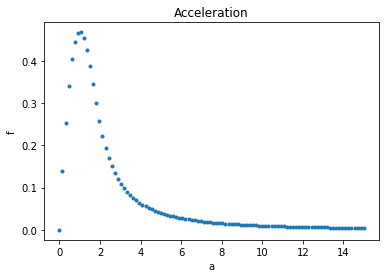

In [3]:
# And we plot them as to visualize the problem.
_ = plt.plot(X, Y, '.')
_ = plt.title('Acceleration')
_ = plt.xlabel('a')
_ = plt.ylabel('f')


## 2 - The symbolic regression problem


In [4]:
# We define our kernel set, that is the mathematical operators we will
# want our final model to possibly contain. What to choose in here is left
# to the competence and knowledge of the user. For this particular application we want to mainly look into rational 
#functions. Note we do not include the difference as that can be obtained via negative constants
ss = dcgpy.kernel_set_double(["sum", "mul","pdiv"])

In [5]:
# We instantiate the symbolic regression optimization problem (note: many important options are here not
# specified and thus set to their default values).
# Note that we allow for three constants in the final expression
udp = dcgpy.symbolic_regression(points = X, labels = Y, kernels=ss(), n_eph=3, rows =1, cols=20, levels_back=21, multi_objective=True)
print(udp)

	Data dimension (points): 1
	Data dimension (labels): 1
	Data size: 100
	Kernels: [sum, mul, pdiv]
	Loss: MSE



## 4 - The search algorithm

In [6]:
# We instantiate here the evolutionary strategy we want to use to search for models.
# In this case we use a multiple objective memetic algorithm.
uda  = dcgpy.momes4cgp(gen = 3000, max_mut = 4)

## 5 - The search

In [7]:
prob = pg.problem(udp)
algo = pg.algorithm(uda)
# Note that the screen output will happen on the terminal, not on your Jupyter notebook.
# It can be recovered afterwards from the log.
algo.set_verbosity(10)
pop = pg.population(prob, 20)

In [8]:
pop = algo.evolve(pop)

In [13]:
# This extract the population individual with lowest loss
idx = np.argmin(pop.get_f(), axis=0)[0]
print("Best loss (MSE) found is: ", pop.get_f()[idx][0])

Best loss (MSE) found is:  0.0002555079686589074


## 6 - Inspecting the solution

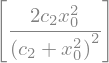

In [9]:
pop.get_f()
# Lets have a look to the symbolic representation of our model (using sympy)
parse_expr(udp.prettier(pop.get_x()[idx]))

In [10]:
# And lets see what our model actually predicts on the inputs
Y_pred = udp.predict(X, pop.get_x()[idx])

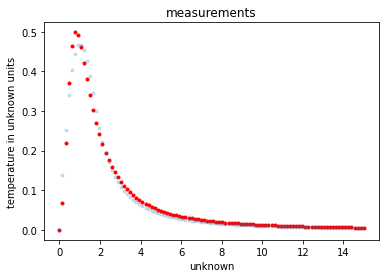

In [12]:
# Lets comapre to the data
_ = plt.plot(X, Y_pred, 'r.')
_ = plt.plot(X, Y, '.', alpha=0.2)
_ = plt.title('measurements')
_ = plt.xlabel('unknown')
_ = plt.ylabel('temperature in unknown units')

In [14]:
print("Values for the constants: ", pop.get_x()[idx][:3])

Values for the constants:  [ 1.43930499  0.63600381 -0.59788675]
